## One-Class SVM Demo on Fraud Dataset

### Required packages and libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
from sklearn.utils.random import sample_without_replacement
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

### Reading dataset from local source, also random sampling without replacement and selecting relevant features

In [3]:
# reading dataset
path = "./creditcard.csv"
data = pd.read_csv(path)

### Supervised Learning and Feature Selection

### Balance negative and positive cases distribution

In [5]:
positive_cases_df, negative_cases_df = data[data.Class == 1], data[data.Class == 0]
positive_cases_df = positive_cases_df.reset_index()
negative_cases_df = negative_cases_df.reset_index()
n_pos_cases, n_neg_cases = positive_cases_df.shape[0], negative_cases_df.shape[0]
n_sample_idx = sample_without_replacement(negative_cases_df.index.max(), n_pos_cases * 4)
negative_cases_df_sample = negative_cases_df.loc[n_sample_idx]
all_cases_df = positive_cases_df.append(negative_cases_df_sample, ignore_index = True)

X_1,y_1 = all_cases_df[all_cases_df.columns[1:-1]], all_cases_df["Class"]
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size = 0.3)
train_distr = (y_train_1.value_counts() / y_train_1.value_counts().sum())
test_distr = (y_test_1.value_counts() / y_test_1.value_counts().sum())

#svc = SVC(C=0.1, kernel="rbf", gamma=0.1)
svc_1 = LinearSVC(C=0.01, penalty="l1", dual=False)
svc_fit_1 = svc_1.fit(X_train_1, y_train_1)
y_pred_train_1 = svc_fit_1.predict(X_train_1)
y_pred_test_1 = svc_fit_1.predict(X_test_1)

model_1 = SelectFromModel(svc_fit_1, prefit=True)
X_new_1 = model_1.transform(X_train_1)

selected_features_1 = list(X_train_1.columns[model_1.get_support()])

print("Training Data Size %d, Label Size %d " % (X_train_1.shape[0], y_train_1.shape[0]))
print("Testing Data Size %d, Label Size %d " % (X_test_1.shape[0], y_test_1.shape[0]))
print("Training Label Distribution %.2f" % (train_distr[1]))
print("Testing Label Distribution %.2f" % (test_distr[1]))
print("Training Accuracy: %.2f, Testing Accuracy: %.2f" % 
      (accuracy_score(y_train_1, y_pred_train_1), accuracy_score(y_test_1, y_pred_test_1)))
print("Training Recall: %.2f, Testing Recall: %.2f" % 
      (recall_score(y_train_1, y_pred_train_1), recall_score(y_test_1, y_pred_test_1)))
print("Training Recall: %.2f, Testing Recall: %.2f" % 
      (precision_score(y_train_1, y_pred_train_1), precision_score(y_test_1, y_pred_test_1)))
print("Selected Feature Size %d" % (X_new_1.shape[1]))

print("Model Based Selected Features", selected_features_1)

Training Data Size 1722, Label Size 1722 
Testing Data Size 738, Label Size 738 
Training Label Distribution 0.20
Testing Label Distribution 0.20
Training Accuracy: 0.97, Testing Accuracy: 0.97
Training Recall: 0.86, Testing Recall: 0.87
Training Recall: 0.97, Testing Recall: 1.00
Selected Feature Size 9
Model Based Selected Features ['V1', 'V3', 'V4', 'V8', 'V10', 'V12', 'V14', 'V17', 'Amount']


In [6]:
scaler_1 = MinMaxScaler(feature_range=[0,1])
X_scl_1 = scaler_1.fit_transform(X_1)
selectBest2 = SelectKBest(chi2, k=2)
X_new_2 = selectBest2.fit_transform(X_scl_1, y_1)
selected_features_2 = list(X_1.columns[selectBest2.get_support()])
print("Selected Feature Size %d" % (X_new_2.shape[1])) 
print("Chi2 Based Selected Features", selected_features_2)

Selected Feature Size 2
Chi2 Based Selected Features ['V4', 'V11']


### One-Class SVM

### Initial Params

In [7]:
sample_size, time_bound = 10000, 1000
list_of_predictors = selected_features_2
name_of_classifier = "Class"
time_based_selection = False
scaler_index = 0 ## 0,1,2
scaler_types = ["minmax", "normalizer", "standart"]
scaler_type = scaler_types[scaler_index]

In [8]:
# reducing dataset
# wheter time based or random sampling
if time_based_selection:
    tmp_list_predictors = list_of_predictors
    tmp_list_predictors.append(name_of_classifier)
    tmp_list_predictors.append("Time")
    data_selc = data[data.Time < time_bound][tmp_list_predictors]
else:
    sample_idx = sample_without_replacement(data.index.max(),sample_size)
    data_selc = data.loc[sample_idx]
    
# setting the X and y dfs
X_2, y_2 = data_selc[list_of_predictors],data_selc[name_of_classifier]
print("Training Set #observations %d - #features %d" % (X_2.shape[0], X_2.shape[1]))
print("Feature Names", list(X_2.columns))
print("Training Set Summary \n", X_2.describe())

Training Set #observations 10000 - #features 2
Feature Names ['V4', 'V11']
Training Set Summary 
                  V4           V11
count  10000.000000  10000.000000
mean      -0.003515     -0.000707
std        1.411630      1.022204
min       -4.790224     -4.224788
25%       -0.862310     -0.769338
50%       -0.006727     -0.029567
75%        0.759242      0.729985
max       10.778184      8.583774


### Min-Max Scaling for the features and hold-out sampling with %30 for the test dataset

In [9]:
# choosing the scaler
if scaler_type == "minmax":
    scaler_2 = MinMaxScaler(feature_range=[-1,1])
elif scaler_type == "normalizer":
    scaler_2 = Normalizer(norm = "l1") #l1,l2,max
elif scaler_type == "standard":
    scaler_2 = StandardScaler()

# scaling the original dataset (X)
X_scl_2 = scaler_2.fit_transform(X_2)

# train-test splitting
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_scl_2, y_2, test_size = 0.4)
# #observations for the train and test selection
n_train_obs, n_test_obs = X_train_2.shape[0], X_test_2.shape[0]
print("#Training Observations %d " % (n_train_obs))
print("#Testing Observations %d " % (n_test_obs))
print("#Features", X_train_2.shape[1])

#Training Observations 6000 
#Testing Observations 4000 
#Features 2


### Bi-variate Analysis

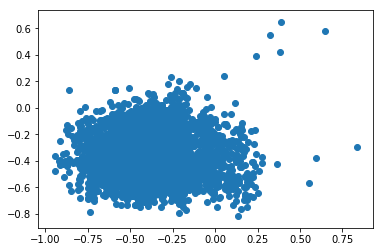

In [10]:
plt.scatter(X_train_2[:,0],X_train_2[:,1])

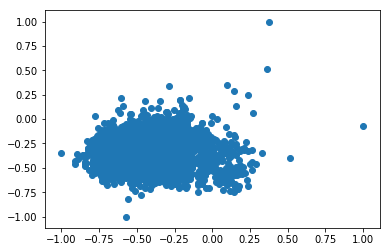

In [11]:
plt.scatter(X_test_2[:,0], X_test_2[:,1])

### Fitting one-class svm model using scaled dataset and model predictions for train and test sets

In [12]:
p_kernel = "rbf" # linear, poly, sigmoid
p_gamma = "auto" # 0.1
p_nu = 0.01 # (0,1]

# fitting the model
# kernel type is radial basis, namely gaussian
# set the gamma 0.1 or auto, auto means  1/n_observations
# nu is the margin for the support vectors
svm_2 = OneClassSVM(kernel = p_kernel, gamma = p_gamma, nu = p_nu) 
svm_fit_2 = svm_2.fit(X_train_2)

# prediction for the train and test set
y_pred_train_2 = svm_fit_2.predict(X_train_2)
y_pred_test_2 = svm_fit_2.predict(X_test_2)

# finding the number of train and test error size
n_error_train = y_pred_train_2[y_pred_train_2 == -1].size
n_error_test = y_pred_test_2[y_pred_test_2 == -1].size
print("Training Error Rate: %.2f" % (n_error_train / y_pred_train_2.size))
print("Testing Error Rate: %.2f" % (n_error_test / y_pred_train_2.size))

Training Error Rate: 0.01
Testing Error Rate: 0.01


### Visualization, Contour and scatter plots

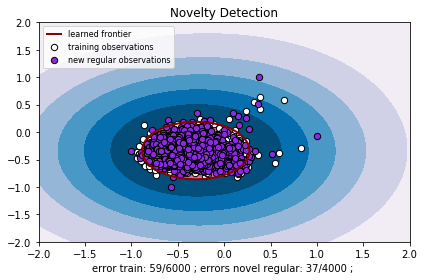

In [13]:
xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-2, 2, 500))
Z = svm_fit_2.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train_2[:, 0], X_train_2[:, 1], c='white', s=s, edgecolors='k')
b2 = plt.scatter(X_test_2[:, 0], X_test_2[:, 1], c='blueviolet', s=s,
                 edgecolors='k')
plt.axis('tight')
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.legend([a.collections[0], b1, b2],
           ["learned frontier", "training observations",
            "new regular observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=8))
plt.xlabel(
    "error train: %d/%d ; errors novel regular: %d/%d ; "
    % (n_error_train, n_train_obs, n_error_test, n_test_obs))
plt.tight_layout()
plt.show()

In [15]:
y_train_2 = y_train_2.reset_index(drop=True)
X_train_3 = pd.DataFrame(X_train_2, columns = list_of_predictors)
X_train_3["Class"] = y_train_2
X_train_3["Pred"] = y_pred_train_2

y_test_2 = y_test_2.reset_index(drop=True)
X_test_3 = pd.DataFrame(X_test_2, columns = list_of_predictors)
X_test_3["Class"] = y_test_2
X_test_3["Pred"] = y_pred_test_2

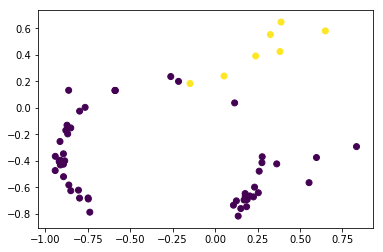

In [16]:
plt.scatter(X_train_3[X_train_3.Pred == -1].V4, X_train_3[X_train_3.Pred == -1].V11,
            c = X_train_3[X_train_3.Pred == -1].Class)

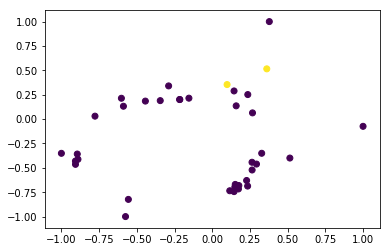

In [17]:
plt.scatter(X_test_3[X_test_3.Pred == -1].V4, X_test_3[X_test_3.Pred == -1].V11,
            c = X_test_3[X_test_3.Pred == -1].Class)